In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

pd.set_option("display.max_columns", 200)

In [3]:
epa = pd.read_csv("../data/annual_aqi_by_county_2024.csv")
cdc = pd.read_csv("../data/CDC PLACES County Data 2024 CSV.csv")

print("EPA columns:", epa.columns.tolist())
print("CDC columns:", cdc.columns.tolist())

EPA columns: ['State', 'County', 'Year', 'Days with AQI', 'Good Days', 'Moderate Days', 'Unhealthy for Sensitive Groups Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI', '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2', 'Days Ozone', 'Days PM2.5', 'Days PM10']
CDC columns: ['Year', 'StateAbbr', 'StateDesc', 'LocationName', 'DataSource', 'Category', 'Measure', 'Data_Value_Unit', 'Data_Value_Type', 'Data_Value', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'TotalPopulation', 'TotalPop18plus', 'LocationID', 'CategoryID', 'MeasureId', 'DataValueTypeID', 'Short_Question_Text', 'Geolocation']


/var/folders/yc/k3nwdz4j5s5fct8vb0_9t0840000gn/T/ipykernel_3299/51727253.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  cdc = pd.read_csv("../data/CDC PLACES County Data 2024 CSV.csv")


In [ ]:
epa["state_key"] = epa["State"].str.strip().str.lower()
epa["county_key"] = epa["County"].str.strip().str.lower()

epa_clean = epa[[
    "state_key", "county_key",
    "Max AQI",
    "Days Ozone",
    "Days PM2.5",
    "Good Days",
    "Moderate Days",
    "Unhealthy for Sensitive Groups Days",
    "Unhealthy Days"
]]

epa_clean.head()

,state_key,county_key,Max AQI,Days Ozone,Days PM2.5,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days
0,alabama,baldwin,90,127,228,278,77,0,0
1,alabama,clay,75,0,354,307,47,0,0
2,alabama,dekalb,87,242,124,277,89,0,0
3,alabama,elmore,58,234,0,231,3,0,0
4,alabama,etowah,93,84,278,212,150,0,0


In [ ]:
cdc["state_key"] = cdc["StateDesc"].str.strip().str.lower()
cdc["county_key"] = cdc["LocationName"].str.strip().str.lower()

print(cdc[["StateDesc", "LocationName"]].head())

  StateDesc LocationName
0   Alabama         Clay
1   Alabama         Dale
2   Alabama      Jackson
3   Alabama   Lauderdale
4   Alabama     Lawrence


In [9]:
measures = [
    "Chronic obstructive pulmonary disease among adults",
    "Current asthma among adults",
    "Fair or poor self-rated health status among adults",
    "Current lack of health insurance among adults aged 18-64 years"
]

cdc_subset = cdc[cdc["Measure"].isin(measures)].copy()

cdc_pivot = cdc_subset.pivot_table(
    index=["state_key", "county_key"],
    columns="Measure",
    values="Data_Value",
    aggfunc="first"
).reset_index()

cdc_pivot.head()

Measure,state_key,county_key,Chronic obstructive pulmonary disease among adults,Current asthma among adults,Current lack of health insurance among adults aged 18-64 years,Fair or poor self-rated health status among adults
0,alabama,autauga,6.8,10.0,9.0,17.7
1,alabama,baldwin,6.4,9.9,6.4,18.5
2,alabama,barbour,9.8,11.2,11.3,30.2
3,alabama,bibb,10.3,10.7,12.2,25.8
4,alabama,blount,10.5,10.5,16.1,22.6


In [10]:
df = epa_clean.merge(cdc_pivot, on=["state_key", "county_key"], how="inner")
df.shape, df.head()

((959, 13),
   state_key county_key  Max AQI  Days Ozone  Days PM2.5  Good Days  \
 0   alabama    baldwin       90         127         228        278   
 1   alabama       clay       75           0         354        307   
 2   alabama     dekalb       87         242         124        277   
 3   alabama     elmore       58         234           0        231   
 4   alabama     etowah       93          84         278        212   
 
    Moderate Days  Unhealthy for Sensitive Groups Days  Unhealthy Days  \
 0             77                                    0               0   
 1             47                                    0               0   
 2             89                                    0               0   
 3              3                                    0               0   
 4            150                                    0               0   
 
    Chronic obstructive pulmonary disease among adults  \
 0                                                6.4   

In [11]:
df = epa_clean.merge(cdc_pivot, on=["state_key", "county_key"], how="inner")
df.shape, df.head()

((959, 13),
   state_key county_key  Max AQI  Days Ozone  Days PM2.5  Good Days  \
 0   alabama    baldwin       90         127         228        278   
 1   alabama       clay       75           0         354        307   
 2   alabama     dekalb       87         242         124        277   
 3   alabama     elmore       58         234           0        231   
 4   alabama     etowah       93          84         278        212   
 
    Moderate Days  Unhealthy for Sensitive Groups Days  Unhealthy Days  \
 0             77                                    0               0   
 1             47                                    0               0   
 2             89                                    0               0   
 3              3                                    0               0   
 4            150                                    0               0   
 
    Chronic obstructive pulmonary disease among adults  \
 0                                                6.4   

In [12]:
df = df.replace("NA", np.nan)
df = df.dropna()
df.shape

(959, 13)

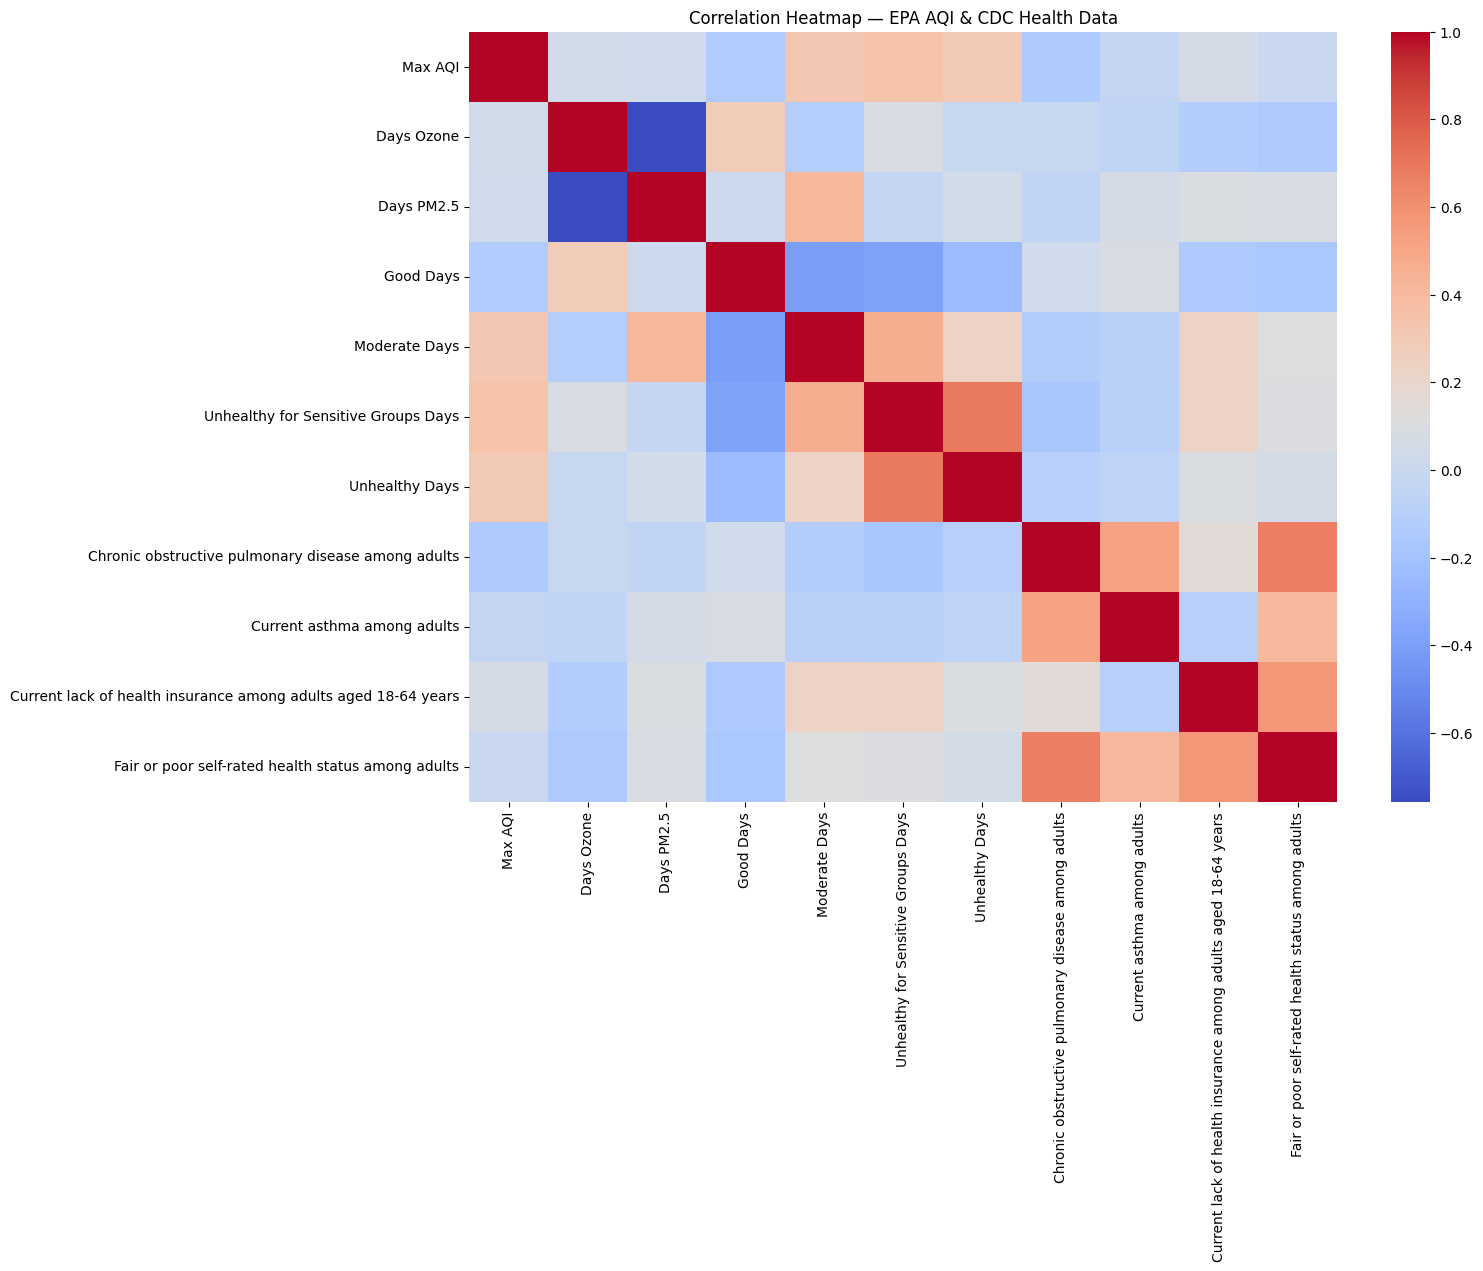

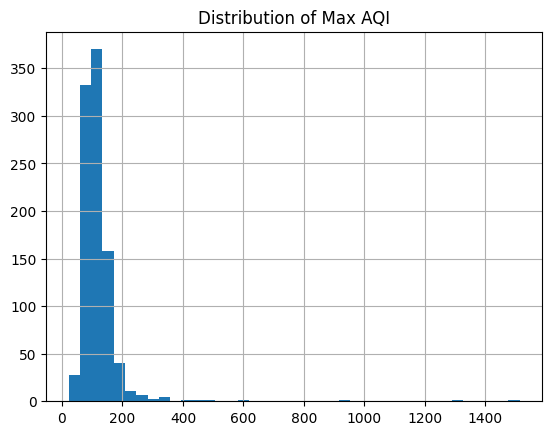

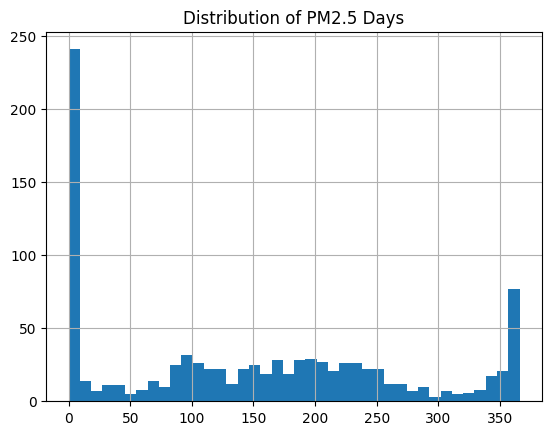

In [14]:
# 只保留数值列做相关性计算
num_df = df.select_dtypes(include="number")

plt.figure(figsize=(14, 10))
sns.heatmap(num_df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap — EPA AQI & CDC Health Data")
plt.show()

# 下面两个直方图保留不变
df["Max AQI"].hist(bins=40)
plt.title("Distribution of Max AQI")
plt.show()

df["Days PM2.5"].hist(bins=40)
plt.title("Distribution of PM2.5 Days")
plt.show()

In [15]:
formula = (
    'Q("Chronic obstructive pulmonary disease among adults") ~ '
    'Q("Max AQI") + Q("Days PM2.5") + Q("Days Ozone") + '
    'Q("Current lack of health insurance among adults aged 18-64 years") + '
    'Q("Days PM2.5"):Q("Current lack of health insurance among adults aged 18-64 years")'
)

model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

                                               OLS Regression Results                                              
Dep. Variable:     Q("Chronic obstructive pulmonary disease among adults")   R-squared:                       0.056
Model:                                                                 OLS   Adj. R-squared:                  0.051
Method:                                                      Least Squares   F-statistic:                     11.37
Date:                                                     Sat, 29 Nov 2025   Prob (F-statistic):           1.13e-10
Time:                                                             20:28:16   Log-Likelihood:                -1958.1
No. Observations:                                                      959   AIC:                             3928.
Df Residuals:                                                          953   BIC:                             3957.
Df Model:                                                               

In [16]:
features = [
    "Max AQI",
    "Days PM2.5",
    "Days Ozone",
    "Current lack of health insurance among adults aged 18-64 years"
]

X = df[features]
y = df["Chronic obstructive pulmonary disease among adults"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
mse = mean_squared_error(y_test, preds)
print("Random Forest MSE:", mse)

fi = (
    pd.DataFrame({"feature": features, "importance": rf.feature_importances_})
    .sort_values("importance", ascending=False)
)
fi

Random Forest MSE: 4.111188774305549


,feature,importance
3,Current lack of health insurance among adults ...,0.311392
0,Max AQI,0.278672
1,Days PM2.5,0.208346
2,Days Ozone,0.201590
